# Module Imports

This code sets up a comprehensive Python environment for developing and evaluating a deep learning–based image classification model using PyTorch. It installs and imports core libraries for numerical computing, image processing, and visualization; loads PyTorch, Torchvision, and optimization utilities for building and training neural networks; includes tools for data handling, augmentation, and class balancing; and integrates evaluation metrics from scikit-learn alongside model inspection utilities (torchinfo) to support end-to-end model training, analysis, and performance visualization.

In [1]:
# Install required packages
!pip install torchinfo

# Standard library imports
import os

# Third-party imports - Core
import numpy as np
from tqdm import tqdm
import cv2
import imutils
from PIL import Image
import kagglehub

# PyTorch imports
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import WeightedRandomSampler, random_split, DataLoader

# Torchvision imports
import torchvision
from torchvision import transforms, models

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics imports
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from torchinfo import summary

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preprocessing

This code sets up a **complete data pipeline for brain tumor MRI classification** using a Kaggle dataset with custom preprocessing and class balancing. It implements a `crop_img` function that uses OpenCV to automatically detect and crop brain regions from MRI scans by finding contours and extreme points, then applies this via a custom `PreprocessingTransform` integrated into PyTorch transforms alongside standard augmentations (random crops, flips, color jitter) for training and center crops for validation/testing, all normalized for EfficientNet. The training data is split 80/20 into train/validation sets, and a `WeightedRandomSampler` is used to handle class imbalance by oversampling underrepresented tumor types. Finally, it creates DataLoaders with batch size 32, multi-worker loading, and GPU memory pinning for efficient training, and prints comprehensive dataset statistics including class distributions.

In [5]:
# ==================== PREPROCESSING FUNCTIONS ====================

def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,
                  extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    return new_img


class PreprocessingTransform:
    """Custom transform to apply crop_img preprocessing"""
    def __call__(self, img):
        # Convert PIL Image to numpy array (RGB)
        img_np = np.array(img)

        # Apply cropping
        try:
            cropped = crop_img(img_np)
            # Convert back to PIL Image
            return Image.fromarray(cropped)
        except:
            # If cropping fails, return original image
            return img


# ==================== DATASET SETUP ====================

# Download dataset
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
DATASET_DIR = path

# ImageNet normalization (standard for EfficientNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# EfficientNet-B0 expects 224x224 input
IMG_SIZE = 224

# Training transforms with preprocessing
train_transforms = torchvision.transforms.Compose([
    PreprocessingTransform(),  # Apply crop_img first
    torchvision.transforms.RandomResizedCrop(IMG_SIZE),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

# Validation/Test transforms with preprocessing
val_transforms = torchvision.transforms.Compose([
    PreprocessingTransform(),  # Apply crop_img first
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(IMG_SIZE),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

# ==================== LOAD DATASETS ====================

# Load full training dataset
full_train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(DATASET_DIR, 'Training')
)

# Split training into train and validation (80/20)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Use random_split to get indices
train_indices, val_indices = random_split(
    range(len(full_train_dataset)),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Create datasets with appropriate transforms
train_dataset = torch.utils.data.Subset(
    torchvision.datasets.ImageFolder(
        os.path.join(DATASET_DIR, "Training"),
        transform=train_transforms
    ),
    train_indices.indices
)

val_dataset = torch.utils.data.Subset(
    torchvision.datasets.ImageFolder(
        os.path.join(DATASET_DIR, "Training"),
        transform=val_transforms
    ),
    val_indices.indices
)

# Load separate test dataset
test_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(DATASET_DIR, 'Testing'),
    transform=val_transforms
)

# ==================== CLASS BALANCING ====================

# Get targets for weighted sampling
train_targets = [full_train_dataset.targets[i] for i in train_indices.indices]

# Calculate class weights
class_sample_counts = torch.bincount(torch.tensor(train_targets))
class_weights = 1. / class_sample_counts.float()

# Create sample weights for each training sample
sample_weights = [class_weights[label] for label in train_targets]

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# ==================== CREATE DATALOADERS ====================

BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True  # Faster data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# ==================== PRINT DATASET INFO ====================

print(f"\nDataset loaded from: {DATASET_DIR}")
print(f"\nDataset splits:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print(f"\nNumber of classes: {len(full_train_dataset.classes)}")
print(f"Classes: {full_train_dataset.classes}")
print(f"\nClass distribution in training set:")
for idx, count in enumerate(class_sample_counts):
    print(f"  {full_train_dataset.classes[idx]}: {count} samples")
print(f"\nBatch size: {BATCH_SIZE}")
print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.

Dataset loaded from: /kaggle/input/brain-tumor-mri-dataset

Dataset splits:
  Training samples: 4569
  Validation samples: 1143
  Test samples: 1311

Number of classes: 4
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

Class distribution in training set:
  glioma: 1051 samples
  meningioma: 1076 samples
  notumor: 1276 samples
  pituitary: 1166 samples

Batch size: 32
Number of batches - Train: 143, Val: 36, Test: 41


# Creation of Custom Transfer Learning Pretrained Model Class

This code implements a **transfer learning classifier** using PyTorch's pre-trained EfficientNet-B0 for 4-class image classification. The `EfficientNetClassifier` class loads ImageNet weights, freezes all convolutional feature extraction layers (making them non-trainable), and replaces the original classifier with a custom head consisting of 40% dropout and a linear layer outputting 4 classes. This approach leverages powerful pre-trained features while only training the final classification layer, making it ideal for smaller datasets where we want to avoid overfitting while benefiting from features learned on ImageNet.

In [8]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        for param in self.base_model.features.parameters(): # Freezes all pre-trained weights
            param.requires_grad = False

        # Unfreezes the last layer before the classifier of EfficientNet.
        # This will allow this layer specifically to be trained
        for param in self.base_model.features[8].parameters():
            param.requires_grad = True

        in_features = self.base_model.classifier[1].in_features

        # Replace the original classifier with a simple two-layer head:
        #   1) Dropout for regularization (p=0.4)
        #   2) Linear layer mapping the base model's output features to the desired number of classes
        # Doing this allows us improve generalization for our image dataset and also will make these layers trainable as well
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


transfer_learning_model = EfficientNetClassifier(num_classes=4).to(device)

print("EfficientNetClassifier Module Summary\n")
summary(
    transfer_learning_model,
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),   # (batch_size, channels, height, width)
    col_names=[
        "input_size",       # input shape
        "output_size",      # output shape
        "num_params",       # number of parameters
        "params_percent",   # % of total params
        "trainable",        # True/False per layer ← THIS IS KEY FOR YOU
    ],
    col_width=20,
    row_settings=["var_names"]
)

EfficientNetClassifier Module Summary



Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Param %              Trainable
EfficientNetClassifier (EfficientNetClassifier)                   [1, 3, 224, 224]     [1, 4]               --                        --              Partial
├─EfficientNet (base_model)                                       [1, 3, 224, 224]     [1, 4]               --                        --              Partial
│    └─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                        --              Partial
│    │    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    (928)                  0.02%              False
│    │    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112, 112]    (1,448)                0.04%              False
│    │    └─Sequential (2)                            

# Training Configuration and Loop Implementation

This code defines the **training setup and execution loops** for the brain tumor classification model using CrossEntropyLoss, Adam optimizer with 0.01 learning rate, and ReduceLROnPlateau scheduler that reduces learning rate by 10x after 3 epochs without validation loss improvement. The `train_loop` performs standard backpropagation with gradient updates while tracking loss and accuracy with tqdm progress bars, while the `test_loop` runs inference in evaluation mode (disabling dropout/batch norm) without gradient computation to calculate validation metrics and trigger learning rate scheduling. Both functions compute per-epoch average loss and classification accuracy, with the validation loop returning accuracy for model checkpoint selection.

In [ ]:
# Loss and optimization functions
criterion = nn.CrossEntropyLoss()
optimizer = Adam(transfer_learning_model.parameters(), lr=0.001)
# Reduces lr by a factor of 0.1 if validation loss hasn't decreased in 3 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
# Training Loop
def train_loop(dataloader, model, loss_fn, optimizer):
  epoch_loss = 0
  correct = 0
  total = 0

  # Set the model to training mode - important for batch normalization and dropout layers
  model.train()
  loop = tqdm(dataloader, leave=True, desc="Training")

  for images, labels in loop:
    images, labels = images.to(device), labels.to(device)

    # Compute prediction and loss
    preds = model(images)
    loss = loss_fn(preds, labels)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

    # Compute Training Accuracy
    _, predicted = torch.max(preds, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  training_acc = 100. * correct / total
  avg_loss = epoch_loss / len(dataloader)
  print(f"\nTraining Loss: {avg_loss:>8f} - Training Accuracy: {training_acc:>0.2f}%\n")

In [ ]:
# Testing Loop
def test_loop(dataloader, model, loss_fn):

    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0

    loop = tqdm(dataloader, leave=True, desc="Validating")

    with torch.no_grad():
        for images, labels in loop:
          images, labels = images.to(device), labels.to(device)

          # Compute predictions and loss
          preds = model(images)
          epoch_loss += loss_fn(preds, labels).item()

          # Accuracy calculation
          _, predicted = torch.max(preds, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(dataloader)
    accuracy = 100. * correct / total
    scheduler.step(avg_loss)
    print(f"\nValidation loss: {avg_loss:>8f} - Validation Accuracy: {accuracy:>0.2f}%\n")
    return accuracy

# Model Training Execution

This code executes the **complete training pipeline** for 20 epochs, alternating between training on the train set and validation on the validation set each epoch. It implements a simple model checkpointing strategy that tracks the best validation accuracy across all epochs and saves the model's state dictionary to `best_model.pth` whenever a new accuracy record is achieved, ensuring the best-performing model is preserved for deployment and testing.

In [ ]:
# Run train and test loops and find best models
NUM_EPOCHS = 20
best_accuracy = 0
for t in range(NUM_EPOCHS):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_loader, transfer_learning_model, criterion, optimizer)
  current_acc = test_loop(val_loader, transfer_learning_model, criterion)

  if current_acc > best_accuracy:
      best_accuracy = current_acc
      torch.save(transfer_learning_model.state_dict(), 'best_model.pth')
      print("🔥Best Model Saved!")
  print("-------------------------------\n")

print("Done!")

Epoch 1
-------------------------------


Training: 100%|██████████| 143/143 [00:34<00:00,  4.09it/s]



Training Loss: 0.650937 - Training Accuracy: 75.22%



Validating: 100%|██████████| 36/36 [00:08<00:00,  4.45it/s]



Validation loss: 0.285089 - Validation Accuracy: 90.29%

🔥Best Model Saved!
-------------------------------

Epoch 2
-------------------------------


Training: 100%|██████████| 143/143 [00:29<00:00,  4.90it/s]



Training Loss: 0.447804 - Training Accuracy: 83.06%



Validating: 100%|██████████| 36/36 [00:06<00:00,  5.44it/s]



Validation loss: 0.262860 - Validation Accuracy: 90.55%

🔥Best Model Saved!
-------------------------------

Epoch 3
-------------------------------


Training: 100%|██████████| 143/143 [00:29<00:00,  4.82it/s]



Training Loss: 0.414930 - Training Accuracy: 84.26%



Validating: 100%|██████████| 36/36 [00:06<00:00,  5.98it/s]



Validation loss: 0.221809 - Validation Accuracy: 91.60%

🔥Best Model Saved!
-------------------------------

Epoch 4
-------------------------------


Training: 100%|██████████| 143/143 [00:30<00:00,  4.75it/s]



Training Loss: 0.378996 - Training Accuracy: 85.75%



Validating: 100%|██████████| 36/36 [00:06<00:00,  5.92it/s]



Validation loss: 0.188615 - Validation Accuracy: 93.35%

🔥Best Model Saved!
-------------------------------

Epoch 5
-------------------------------


Training: 100%|██████████| 143/143 [00:29<00:00,  4.83it/s]



Training Loss: 0.365162 - Training Accuracy: 86.67%



Validating: 100%|██████████| 36/36 [00:06<00:00,  5.35it/s]



Validation loss: 0.216891 - Validation Accuracy: 92.21%

-------------------------------

Epoch 6
-------------------------------


Training: 100%|██████████| 143/143 [00:29<00:00,  4.88it/s]



Training Loss: 0.344598 - Training Accuracy: 86.67%



Validating: 100%|██████████| 36/36 [00:06<00:00,  5.32it/s]



Validation loss: 0.192478 - Validation Accuracy: 92.56%

-------------------------------

Epoch 7
-------------------------------


Training: 100%|██████████| 143/143 [00:29<00:00,  4.80it/s]



Training Loss: 0.345128 - Training Accuracy: 87.17%



Validating: 100%|██████████| 36/36 [00:07<00:00,  4.93it/s]



Validation loss: 0.182704 - Validation Accuracy: 92.83%

-------------------------------

Epoch 8
-------------------------------


Training: 100%|██████████| 143/143 [00:30<00:00,  4.74it/s]



Training Loss: 0.327882 - Training Accuracy: 87.59%



Validating: 100%|██████████| 36/36 [00:06<00:00,  5.16it/s]



Validation loss: 0.148917 - Validation Accuracy: 94.31%

🔥Best Model Saved!
-------------------------------

Epoch 9
-------------------------------


Training: 100%|██████████| 143/143 [00:30<00:00,  4.72it/s]



Training Loss: 0.313869 - Training Accuracy: 88.03%



Validating: 100%|██████████| 36/36 [00:07<00:00,  5.03it/s]



Validation loss: 0.162092 - Validation Accuracy: 93.53%

-------------------------------

Epoch 10
-------------------------------


Training: 100%|██████████| 143/143 [00:29<00:00,  4.89it/s]



Training Loss: 0.319810 - Training Accuracy: 88.07%



Validating: 100%|██████████| 36/36 [00:07<00:00,  4.88it/s]



Validation loss: 0.170593 - Validation Accuracy: 93.44%

-------------------------------

Epoch 11
-------------------------------


Training: 100%|██████████| 143/143 [00:28<00:00,  4.97it/s]



Training Loss: 0.310607 - Training Accuracy: 88.29%



Validating: 100%|██████████| 36/36 [00:07<00:00,  5.02it/s]



Validation loss: 0.164459 - Validation Accuracy: 94.23%

-------------------------------

Epoch 12
-------------------------------


Training: 100%|██████████| 143/143 [00:28<00:00,  5.09it/s]



Training Loss: 0.297372 - Training Accuracy: 88.68%



Validating: 100%|██████████| 36/36 [00:07<00:00,  4.92it/s]



Validation loss: 0.166133 - Validation Accuracy: 93.53%

-------------------------------

Epoch 13
-------------------------------


Training: 100%|██████████| 143/143 [00:28<00:00,  5.03it/s]



Training Loss: 0.319224 - Training Accuracy: 87.87%



Validating: 100%|██████████| 36/36 [00:06<00:00,  5.83it/s]



Validation loss: 0.155049 - Validation Accuracy: 94.58%

🔥Best Model Saved!
-------------------------------

Epoch 14
-------------------------------


Training: 100%|██████████| 143/143 [00:29<00:00,  4.91it/s]



Training Loss: 0.286451 - Training Accuracy: 89.23%



Validating: 100%|██████████| 36/36 [00:06<00:00,  5.88it/s]



Validation loss: 0.149924 - Validation Accuracy: 94.66%

🔥Best Model Saved!
-------------------------------

Epoch 15
-------------------------------


Training: 100%|██████████| 143/143 [00:29<00:00,  4.89it/s]



Training Loss: 0.281701 - Training Accuracy: 89.32%



Validating: 100%|██████████| 36/36 [00:06<00:00,  5.78it/s]



Validation loss: 0.145912 - Validation Accuracy: 94.66%

-------------------------------

Epoch 16
-------------------------------


Training: 100%|██████████| 143/143 [00:28<00:00,  5.06it/s]



Training Loss: 0.277841 - Training Accuracy: 89.82%



Validating: 100%|██████████| 36/36 [00:07<00:00,  5.11it/s]



Validation loss: 0.140618 - Validation Accuracy: 94.58%

-------------------------------

Epoch 17
-------------------------------


Training: 100%|██████████| 143/143 [00:28<00:00,  5.03it/s]



Training Loss: 0.274409 - Training Accuracy: 90.19%



Validating: 100%|██████████| 36/36 [00:07<00:00,  5.05it/s]



Validation loss: 0.139917 - Validation Accuracy: 94.84%

🔥Best Model Saved!
-------------------------------

Epoch 18
-------------------------------


Training: 100%|██████████| 143/143 [00:28<00:00,  5.03it/s]



Training Loss: 0.288030 - Training Accuracy: 89.06%



Validating: 100%|██████████| 36/36 [00:07<00:00,  5.06it/s]



Validation loss: 0.139957 - Validation Accuracy: 94.58%

-------------------------------

Epoch 19
-------------------------------


Training: 100%|██████████| 143/143 [00:28<00:00,  5.06it/s]



Training Loss: 0.271649 - Training Accuracy: 89.60%



Validating: 100%|██████████| 36/36 [00:06<00:00,  5.89it/s]



Validation loss: 0.136969 - Validation Accuracy: 94.40%

-------------------------------

Epoch 20
-------------------------------


Training: 100%|██████████| 143/143 [00:29<00:00,  4.85it/s]



Training Loss: 0.256156 - Training Accuracy: 90.19%



Validating: 100%|██████████| 36/36 [00:06<00:00,  5.94it/s]


Validation loss: 0.146896 - Validation Accuracy: 94.23%

-------------------------------

Done!


# Model Evaluation and Results Visualization

This code performs **final model evaluation on the held-out test set** by loading the best saved model checkpoint and running inference to collect all true labels and predictions. The `evaluate_model` function runs the model in eval mode without gradient computation to efficiently generate predictions, while `test_and_display_results` calculates key performance metrics (accuracy and weighted F1-score) and visualizes model performance through a confusion matrix heatmap showing per-class prediction patterns across the four tumor types (glioma, meningioma, no tumor, pituitary), providing comprehensive insight into where the model succeeds and struggles.

In [ ]:
# Run evaluation loop
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

In [ ]:
def test_and_display_results():
    # load best model
    best_model = EfficientNetClassifier(num_classes=4).to(device)
    best_model.load_state_dict(torch.load('best_model.pth'))
    y_true, y_pred = evaluate_model(best_model, test_loader)

    # Convert to numpy if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Metrics (scikit-learn)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Set Accuracy: {accuracy:.4f}")
    print(f"Test Set F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    classnames = ['glioma', 'meningioma', 'notumor', 'pituitary']

    plt.figure(figsize=(8, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=classnames,
        yticklabels=classnames
    )

    plt.xlabel('Predicted')
    plt.ylabel('True / Actual')
    plt.title('Confusion Matrix - Brain Tumor Classification')
    plt.show()


Test Set Accuracy: 0.9428
Test Set F1 Score: 0.9427


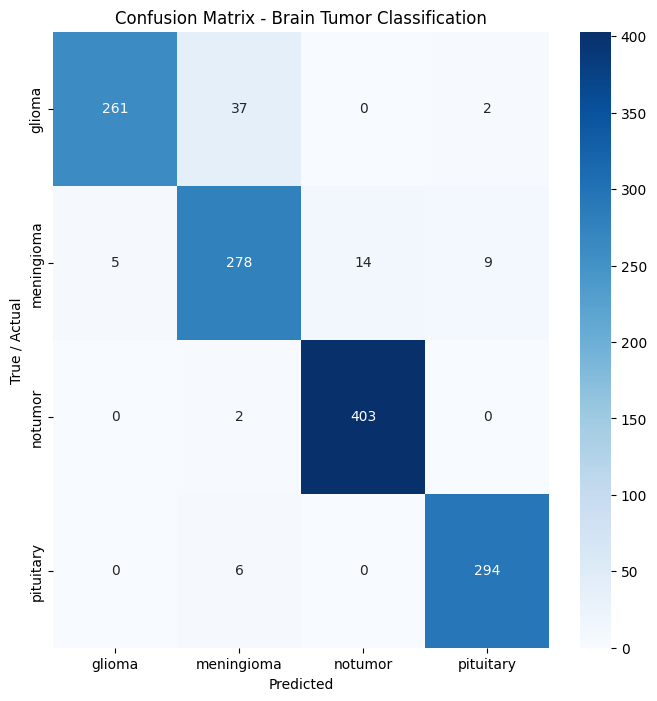

In [ ]:
test_and_display_results()

# References
- https://www.kaggle.com/code/skrohinahmed/brain-tumor-99-92
- https://docs.pytorch.org/vision/main/models.html
- https://www.kaggle.com/code/anantpandey29/gentle-introduction-to-transfer-learning
- https://www.kaggle.com/code/anantpandey29/pytorch-implementation-of-efficientnet
- https://debuggercafe.com/transfer-learning-using-efficientnet-pytorch/
- https://docs.pytorch.org/docs/stable/data.html
- https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0
- https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
- https://github.com/TylerYep/torchinfo

 # AI Usage
 Claude AI was used to combine specific preprocessing code that we found online (created by the person who compiled the dataset) in the Data Preprocessing section with our initial dataset creation code. During testing, our validation loss was incorrect due to errors in how we constructed the validation dataset. Claude also helped fix this issue while integrating our code with the preprocessing code provided by the dataset creator from [this GitHub repository](https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py). Additionally, Claude was used to generate the section descriptions. Grok was also used to make the output of the model summary in the Creation of Custom Transfer Learning Pretrained Model Class section more verbose and descriptive than our original version.